# Import libraries

In [1]:
# pip install torchviz

In [2]:
# pip install torchsummary 

In [55]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt  
from PIL import Image 
import os 
import glob as gb 
from tqdm.auto import tqdm

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam 
import torchvision 
from torchvision import datasets 
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor , CenterCrop
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary
from torchviz import make_dot

# Loading our dataset & Turning our data into tensors

In [4]:
def walk_through_data(dir_path) : 
    for dirpath , dirnames , filenames in tqdm(os.walk(dir_path)) : 
        print(f"There are {len(dirnames)} directions and {len(filenames)} images in {dirpath}")

In [5]:
dataset_dir = '/kaggle/input/easyportrait/'

In [6]:
walk_through_data(dataset_dir)

0it [00:00, ?it/s]

There are 2 directions and 0 images in /kaggle/input/easyportrait/
There are 4 directions and 0 images in /kaggle/input/easyportrait/annotations
There are 0 directions and 1 images in /kaggle/input/easyportrait/annotations/meta
There are 0 directions and 2000 images in /kaggle/input/easyportrait/annotations/val
There are 0 directions and 4000 images in /kaggle/input/easyportrait/annotations/test
There are 0 directions and 14001 images in /kaggle/input/easyportrait/annotations/train
There are 3 directions and 0 images in /kaggle/input/easyportrait/images
There are 0 directions and 2000 images in /kaggle/input/easyportrait/images/val
There are 0 directions and 4000 images in /kaggle/input/easyportrait/images/test
There are 0 directions and 14000 images in /kaggle/input/easyportrait/images/train


In [7]:
train_images_dir = os.path.join(dataset_dir, 'images/train')
train_masks_dir = os.path.join(dataset_dir, 'annotations/train')

test_images_dir = os.path.join(dataset_dir, 'images/test')
test_masks_dir = os.path.join(dataset_dir, 'annotations/test')

val_images_dir = os.path.join(dataset_dir, 'images/val')
val_masks_dir = os.path.join(dataset_dir, 'annotations/val')

In [8]:
images_extension = [] 

for path in tqdm(os.listdir(train_images_dir)) : 
    if os.path.isfile(train_images_dir + "/" + path) : 
        images_extension.append(os.path.splitext(path)[1])
        
        
for path in tqdm(os.listdir(test_images_dir)) : 
    if os.path.isfile(test_images_dir + "/" + path) : 
        images_extension.append(os.path.splitext(path)[1])
        
        
for path in tqdm(os.listdir(val_images_dir)) : 
    if os.path.isfile(val_images_dir + "/" + path) : 
        images_extension.append(os.path.splitext(path)[1])

  0%|          | 0/14000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
print(len(images_extension) , np.unique(images_extension))

20000 ['.jpg']


In [10]:
masks_extension = [] 

for path in tqdm(os.listdir(train_masks_dir)) : 
    if os.path.isfile(train_masks_dir + "/" + path) : 
        masks_extension.append(os.path.splitext(path)[1])
        
        
for path in tqdm(os.listdir(test_masks_dir)) : 
    if os.path.isfile(test_masks_dir + "/" + path) : 
        masks_extension.append(os.path.splitext(path)[1])
        
        
for path in tqdm(os.listdir(val_masks_dir)) : 
    if os.path.isfile(val_masks_dir + "/" + path) : 
        masks_extension.append(os.path.splitext(path)[1])

  0%|          | 0/14001 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
print(len(masks_extension) , np.unique(masks_extension))

20001 ['.png' '.tmp']


In [12]:
img_size = 512

In [13]:
basic_transform = transforms.Compose([
    transforms.Resize(size = (img_size , img_size)) , 
    transforms.ToTensor()
])

In [14]:
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [15]:
class CustomData(Dataset) : 
    def __init__(self, images_dir , masks_dir , transform_method) : 
        self.image_path = sorted(gb.glob(os.path.join(images_dir, '*'))) 
        self.mask_path = sorted(gb.glob(os.path.join(masks_dir, '*'))) 
        self.transform = transform_method 
        if len(self.image_path) != len(self.mask_path) : 
            raise InvalidDatasetException(self.image_path , self.mask_path)
            
            
    def __len__(self) : 
        return len(self.image_path)
    
    
    def __getitem__(self , index) : 
        image = Image.open(self.image_path[index])
        tensor_image = self.transform(image)
        
        mask = Image.open(self.mask_path[index])
        tensor_mask = self.transform(mask)
        
        
        return tensor_image , tensor_mask 

In [16]:
train_set = CustomData(train_images_dir , train_masks_dir , basic_transform)

In [17]:
print(f"The number of images in the train set is : {train_set.__len__()}")

The number of images in the train set is : 14000


In [18]:
filer_train=train_set.__getitem__(1000)

In [19]:
filer_train[0].shape , filer_train[1].shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [20]:
test_set = CustomData(test_images_dir , test_masks_dir , basic_transform)

In [21]:
print(f"The number of images in the test set is : {test_set.__len__()}")

The number of images in the test set is : 4000


In [22]:
filer_test=test_set.__getitem__(1000)

In [23]:
filer_test[0].shape , filer_test[1].shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [24]:
val_set = CustomData(val_images_dir , val_masks_dir , basic_transform)

In [25]:
print(f"The number of images in the val set is : {val_set.__len__()}")

The number of images in the val set is : 2000


In [26]:
filer_val=val_set.__getitem__(1000)

In [27]:
filer_val[0].shape , filer_val[1].shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

# Create dataloaders

In [28]:
BATCH_SIZE = 8

In [29]:
torch.manual_seed(42)
train_dataloader = DataLoader(
    dataset = train_set , 
    batch_size= BATCH_SIZE , 
    shuffle = True 
)

In [30]:
torch.manual_seed(42)
test_dataloader = DataLoader(
    dataset = test_set , 
    batch_size = BATCH_SIZE , 
    shuffle = False
)

In [31]:
torch.manual_seed(42)
val_dataloader = DataLoader(
    dataset = val_set , 
    batch_size = BATCH_SIZE , 
    shuffle = False
)

In [32]:
print(f"the size of the train dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

the size of the train dataloader 1750 batches of 8


In [33]:
print(f"the size of the test dataloader {len(test_dataloader)} batches of {BATCH_SIZE}")

the size of the test dataloader 500 batches of 8


In [34]:
print(f"the size of the validation dataloader {len(val_dataloader)} batches of {BATCH_SIZE}")

the size of the validation dataloader 250 batches of 8


In [35]:
trainimage_sample , trainmask_sample = next(iter(train_dataloader))
trainimage_sample.shape , trainmask_sample.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 1, 512, 512]))

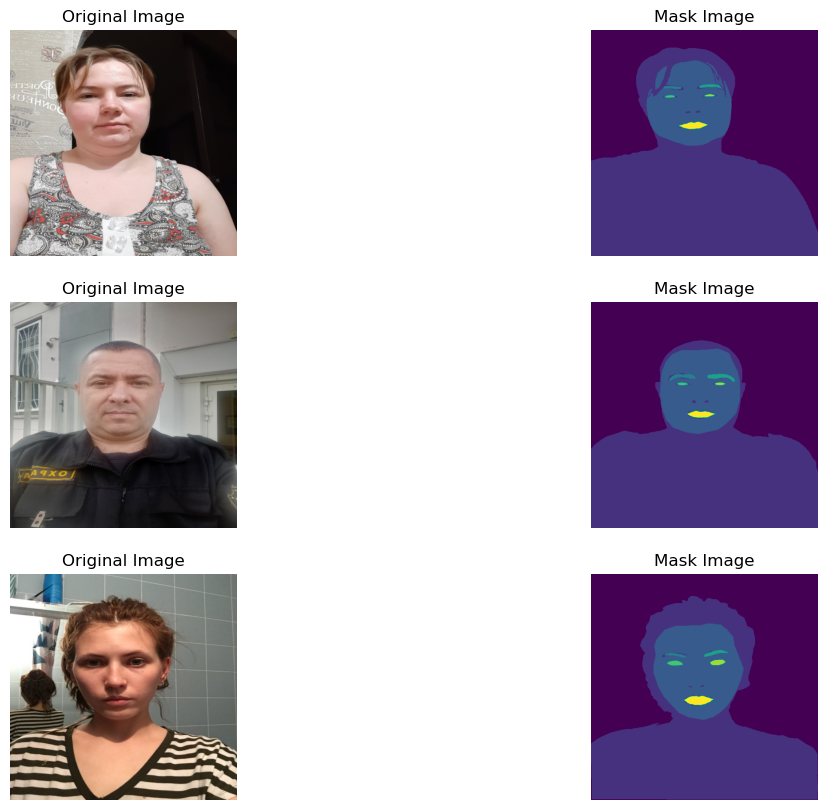

In [36]:
fig , axis = plt.subplots(3 , 2 , figsize = (15,10)) 
for i in range(3): 
    img1 = trainimage_sample[i].numpy()
    img1 = np.transpose(img1, (1,2,0))
    axis[i, 0].imshow(img1)
    axis[i, 0].set(title = f"Original Image")
    axis[i, 0].axis('off')
    
    
    img2 = trainmask_sample[i].numpy()
    img2 = np.transpose(img2, (1,2,0))
    axis[i, 1].imshow(img2)
    axis[i, 1].set(title = f"Mask Image")
    axis[i, 1].axis('off')

plt.subplots_adjust(wspace=0.0)

# Build the model

In [37]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [38]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('Total number of parameters : ', sum(params))

# 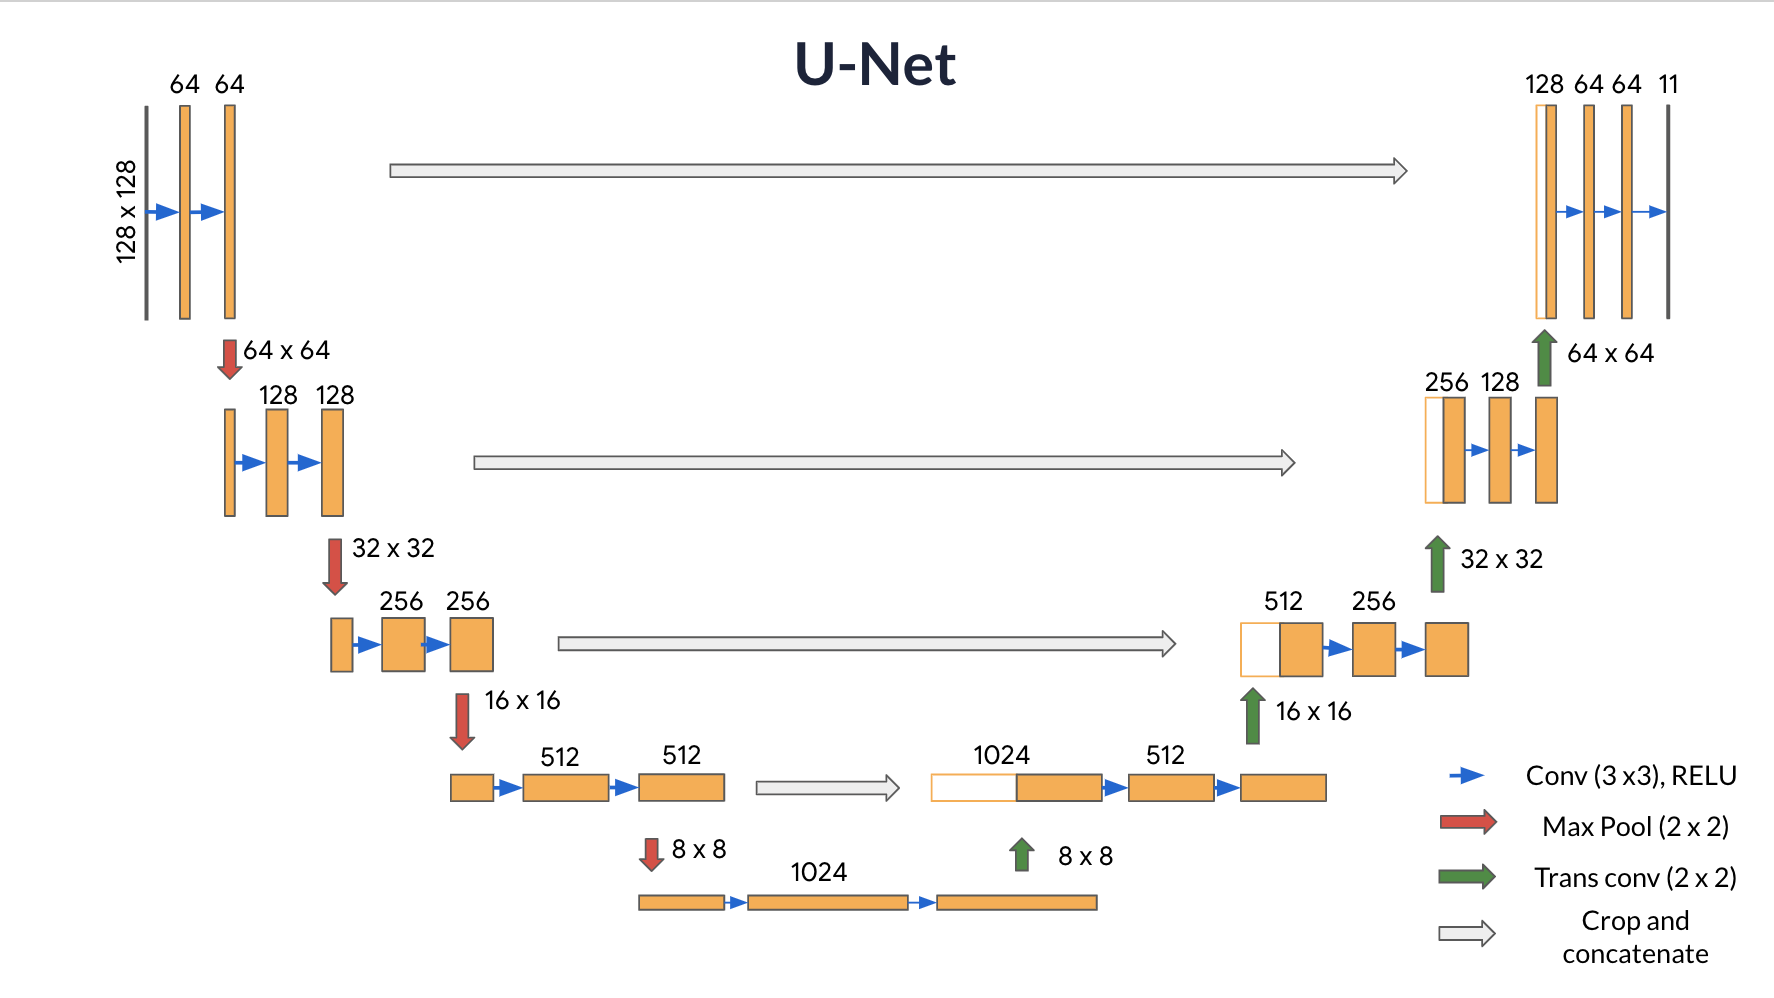

In [39]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x: torch.Tensor):
        return self.block(x)

In [40]:
class CopyAndCrop(nn.Module):
    def forward(self, x: torch.Tensor, skip_connection: torch.Tensor):
        _, _, h, w = skip_connection.shape
        crop = CenterCrop((h, w))(x)
        residual = torch.cat((x, crop), dim=1)
        
        return residual

In [41]:
class UNET(nn.Module) : 
    def __init__(self , in_channels, out_channels) : 
        
        super().__init__() 
        
        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        
        self.pool = nn.MaxPool2d(2)
        
        self.copyAndCrop = CopyAndCrop()
        
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])
        
        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])
        
        self.bottleneck = ConvBlock(512, 1024)
        
        self.finalconv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
        
    def forward(self , x ) : 
        
        skip_connections = []
               
        # Encoding 
        
        for enc in self.encoders:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        
        # Decoding
        
        for idx, dec in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            skip_connection = skip_connections.pop()
            x = self.copyAndCrop(x, skip_connection)
            x = dec(x)
            
        x = self.finalconv(x) 
        
        
        return x 
    
             

In [42]:
model=UNET(
    in_channels= 3 , 
    out_channels=1
).to(device)

In [43]:
model.parameters

<bound method Module.parameters of UNET(
  (encoders): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
     

In [44]:
param_count(model)

Total number of parameters :  31043521


In [45]:
in_shape = (3, img_size, img_size)
print(summary(model, (in_shape)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         ConvBlock-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

In [46]:
dummy_x = torch.rand(size=(3,512,512)).to(device)
dummy_x.shape
dummy_y = model(dummy_x.unsqueeze(0))

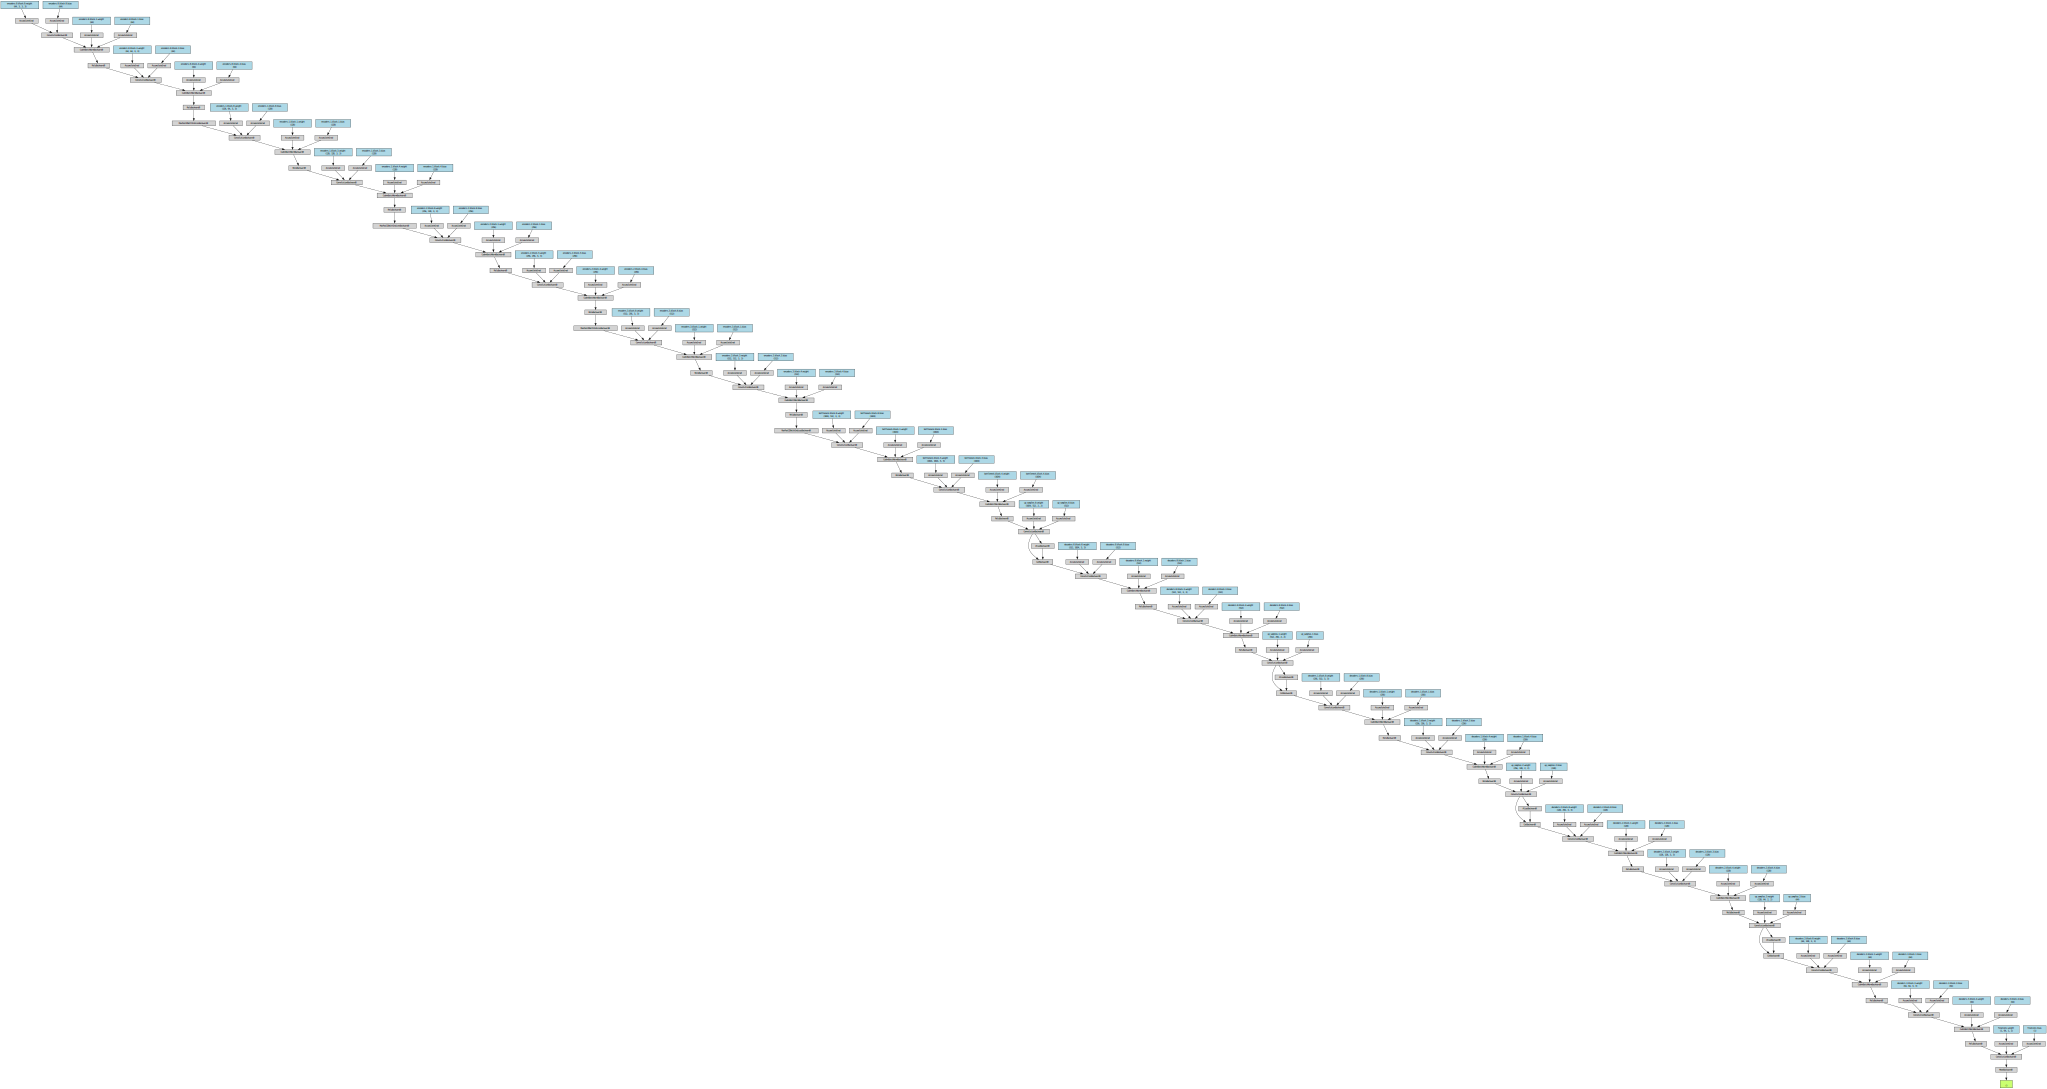

In [47]:
make_dot(dummy_y.mean(), params=dict(model.named_parameters()))

In [48]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

# Train our model 

In [49]:
epochs = 4
training_loss = [] 

for i in tqdm(range(epochs)) : 
    epoch_loss = 0 
    
    for batch , (image , mask) in enumerate(train_dataloader) : 
        
        image , mask = image.to(device) , mask.to(device)
        
        mask_pred = model(image) 
        
        loss = criterion(mask_pred , mask)
        
        if batch % 500 == 0:
            print(f"Looked at {batch * len(image)}/{len(train_dataloader.dataset)} samples.")
            
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
        
        epoch_loss +=loss.item()
        
    training_loss.append((epoch_loss/len(train_dataloader)))
    
    print(f"Epoch : {i} , Loss: {(epoch_loss/len(train_dataloader))}\n\n")
        

  0%|          | 0/4 [00:00<?, ?it/s]

Looked at 0/14000 samples.
Looked at 4000/14000 samples.
Looked at 8000/14000 samples.
Looked at 12000/14000 samples.
Epoch : 0 , Loss: 0.07138109426306827


Looked at 0/14000 samples.
Looked at 4000/14000 samples.
Looked at 8000/14000 samples.
Looked at 12000/14000 samples.
Epoch : 1 , Loss: 0.0169749123044312


Looked at 0/14000 samples.
Looked at 4000/14000 samples.
Looked at 8000/14000 samples.
Looked at 12000/14000 samples.
Epoch : 2 , Loss: 0.01602147888605084


Looked at 0/14000 samples.
Looked at 4000/14000 samples.
Looked at 8000/14000 samples.
Looked at 12000/14000 samples.
Epoch : 3 , Loss: 0.015858085599860974




In [50]:
print(f"The loss of the training set is : {training_loss[-1]}")

The loss of the training set is : 0.015858085599860974


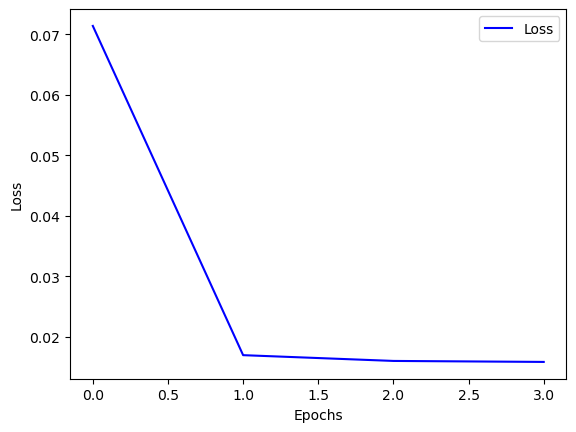

In [51]:
plt.plot(range(epochs) , training_loss,color="blue",label="Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate our model 

In [109]:
test_loss = 0

with torch.no_grad() : 
    
    for image , mask in tqdm(test_dataloader) : 
        
        image , mask = image.to(device) , mask.to(device)
        
        mask_pred = model(image)

        loss = criterion(mask_pred , mask) 
        
        test_loss += loss
        
test_loss/=len(test_dataloader)

  0%|          | 0/500 [00:00<?, ?it/s]

In [110]:
print(f"The loss of the testing set is : {test_loss}\n")

The loss of the testing set is : 0.01480915304273367



# Make predictions

In [105]:
def plot_pred_img(img_sample , mask_sample , val_pred):
    fig , axis = plt.subplots(8 , 3 , figsize = (20,20)) 
    for i in range(8): 
        img1 = img_sample[i].numpy()
        img1 = np.transpose(img1, (1,2,0))
        axis[i, 0].imshow(img1)
        axis[i, 0].set(title = f"Original Image")
        axis[i, 0].axis('off')
    
    
        img2 = mask_sample[i].numpy()
        img2 = np.transpose(img2, (1,2,0))
        axis[i, 1].imshow(img2)
        axis[i, 1].set(title = f"Mask Image")
        axis[i, 1].axis('off')
        
        img3 = val_pred[i].cpu().numpy()
        img3 = np.transpose(img3, (1,2,0))
        axis[i, 2].imshow(img3)
        axis[i, 2].set(title = f"Predicted Mask Image")
        axis[i, 2].axis('off')

    plt.subplots_adjust(wspace=0.5)

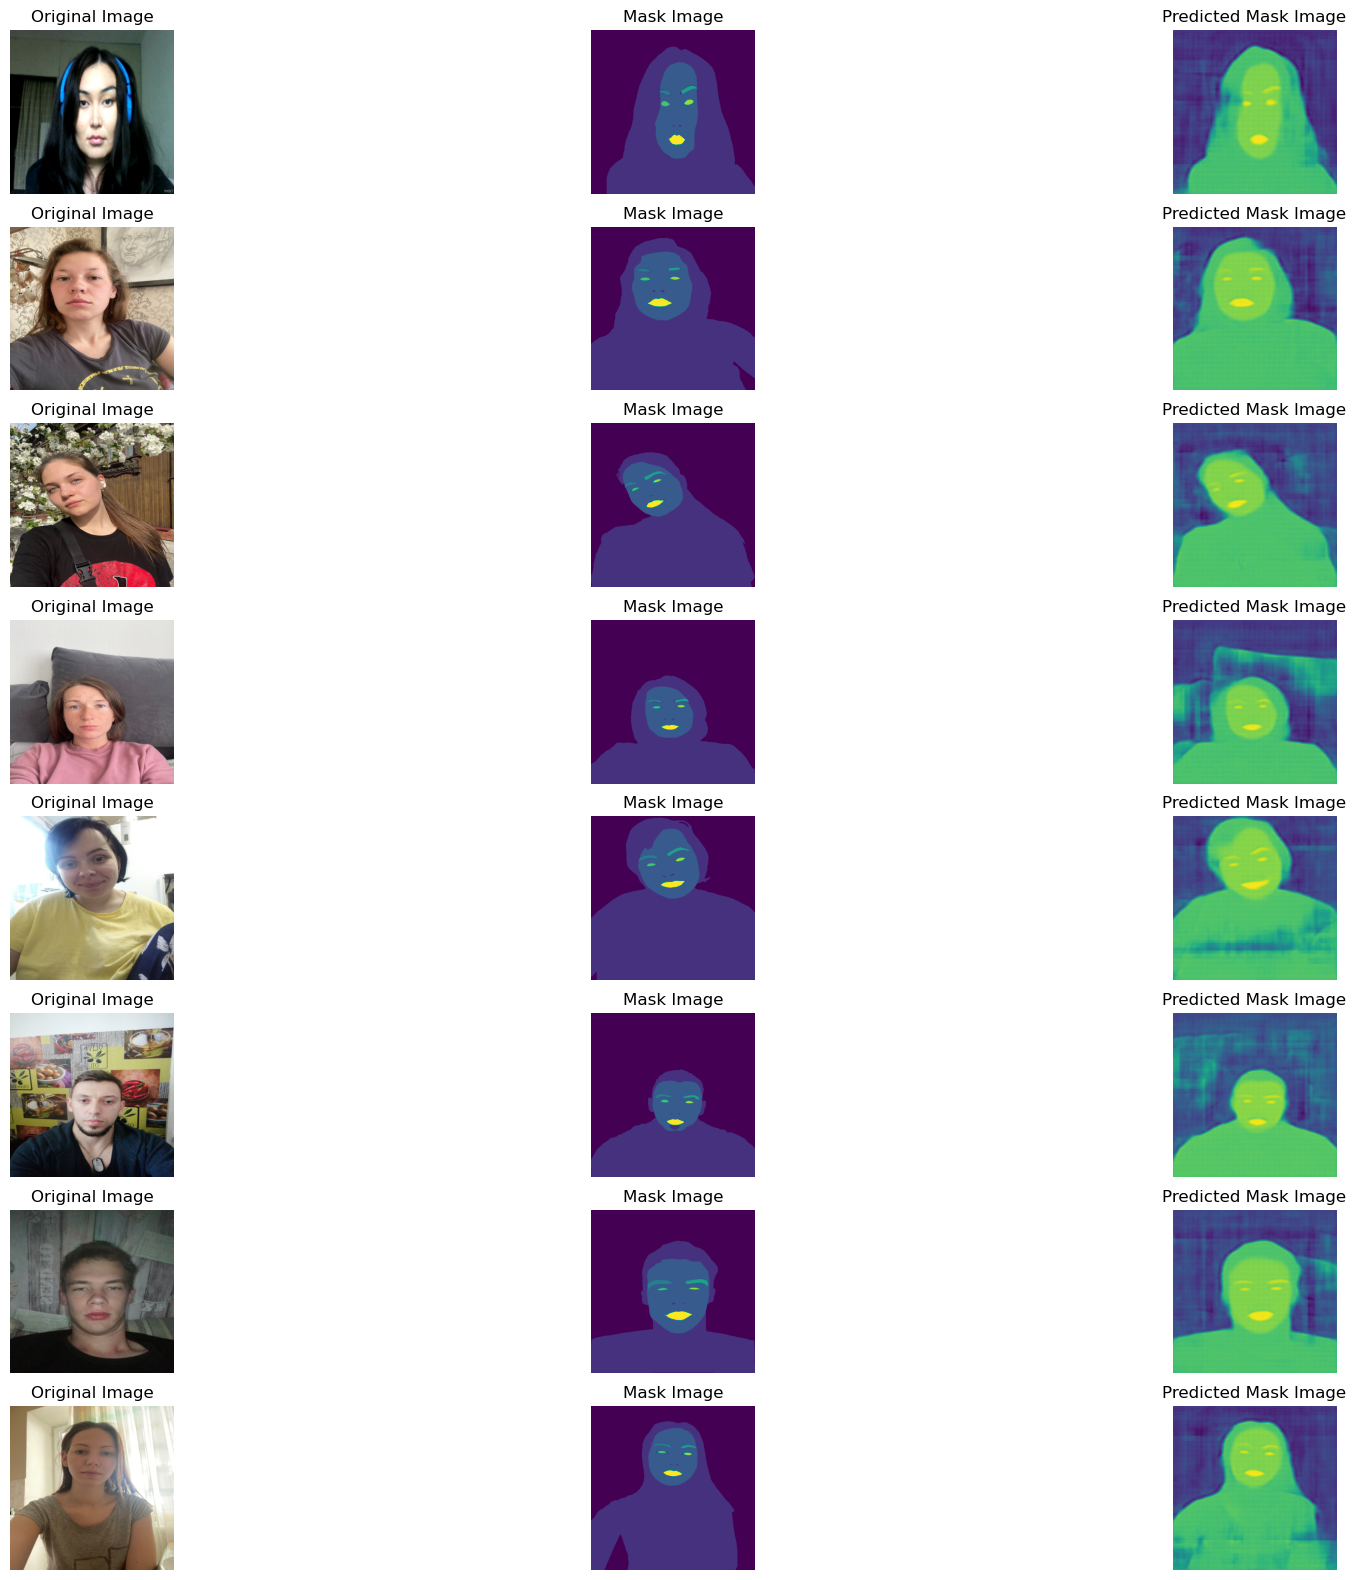

In [106]:
with torch.no_grad() : 
        img_sample , mask_sample = next(iter(val_dataloader)) 
        
        img_sample , mask_sample = img_sample.to(device) , mask_sample.to(device) 
        
        val_pred = model(img_sample)
        
        plot_pred_img(img_sample.cpu() , mask_sample.cpu() , val_pred.detach())

# Save our model

In [111]:
torch.save(model.state_dict(), 'Face Parsing & Portrait Segmentation.pt')